# 入場者数の分析

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [15, 10]

## データのロード

In [2]:
# 大黒、アジに絞ってデータベース検索

conn = sqlite3.connect("../fishing_result.db")
sql = '''
select
    r.Date,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Species = 'アジ'
    and r.Point = 'Daikoku'
'''
df=pd.read_sql_query(sql, conn)

In [3]:
# 土日祝日化判定

df['Date'] = pd.to_datetime(df.Date)
def isBizDay(Date):
    #Date = datetime.date(int(DATE[0:4]), int(DATE[4:6]), int(DATE[6:8]))
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 0
    else:
        return 1

df['BizDay'] = df.apply(lambda x: isBizDay(x.Date), axis=1)

In [4]:
# 日付を索引にセット

df = df.set_index('Date')

In [6]:
df.head()

,Count,SizeMin,SizeMax,WaterTemp,Quantity,BizDay
Date,,,,,,
2021-04-02,147.0,10.0,25.0,16.0,289.0,1
2021-04-01,134.0,13.0,25.0,16.0,232.0,1
2021-03-31,130.0,15.0,25.0,15.5,298.0,1
2021-03-30,192.0,15.0,20.0,15.0,305.0,1
2021-03-29,42.0,13.0,17.0,14.0,299.0,1


## 平日、休日の入場者数比較

<AxesSubplot:xlabel='BizDay', ylabel='Quantity'>

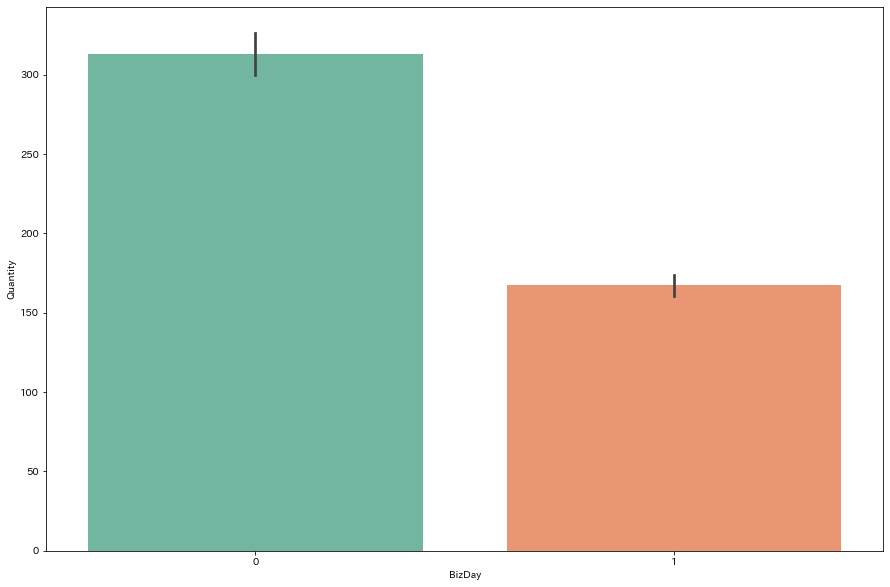

In [5]:
# 入場者数の分析、BizDay : 0が休日、1が平日

sns.barplot(x='BizDay', y='Quantity', data=df, palette='Set2')

In [65]:
# seaborn でプロットしやすいように横縦変換する

df2 = df[['Count', 'SizeMin', 'SizeMax','WaterTemp', 'Quantity']]
df2 = df2.stack().reset_index()
df2 = df2.rename(columns={'level_1': 'Metric', 0: 'Value'})
df2.head()

,Date,Metric,Value
0,2021-04-02,Count,147.0
1,2021-04-02,SizeMin,10.0
2,2021-04-02,SizeMax,25.0
3,2021-04-02,WaterTemp,16.0
4,2021-04-02,Quantity,289.0


In [66]:
# 平日、休日判定列を追加
df2['BizDay'] = df2.apply(lambda x: isBizDay(x.Date), axis=1)

In [67]:
# 日付を索引にセットして、各年月日列を追加
df3 = df2.set_index('Date')
df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['DayOfYear'] = df3.index.dayofyear
df3['WeekOfYear'] = df3.index.weekofyear
df3.head()

<ipython-input-67-71bac162e0f8>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df3['WeekOfYear'] = df3.index.weekofyear


,Metric,Value,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,
2021-04-02,Count,147.0,1,2021,4,92,13
2021-04-02,SizeMin,10.0,1,2021,4,92,13
2021-04-02,SizeMax,25.0,1,2021,4,92,13
2021-04-02,WaterTemp,16.0,1,2021,4,92,13
2021-04-02,Quantity,289.0,1,2021,4,92,13


## 平日、休日のアジ釣果サイズの比較

<AxesSubplot:xlabel='Metric', ylabel='Value'>

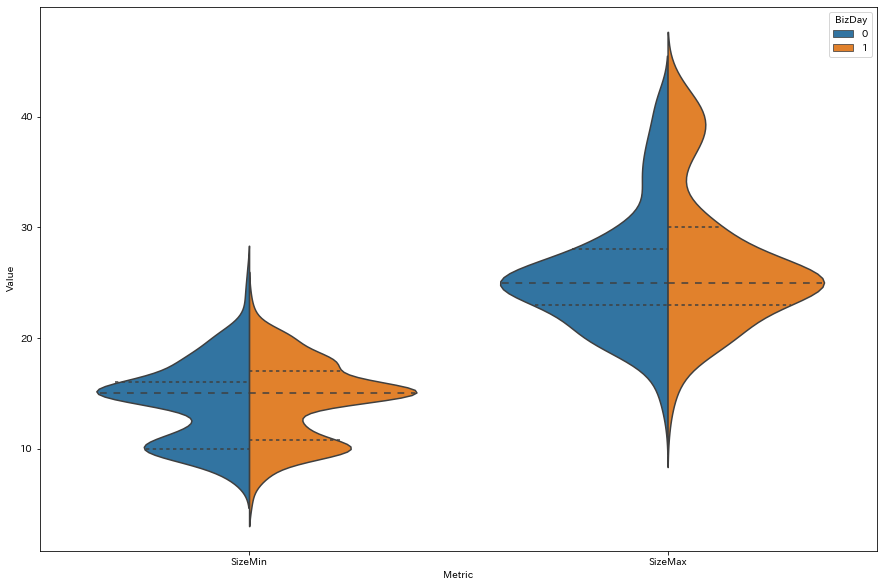

In [69]:
# サイズに絞り込んでプロット
df5 = df3.loc[df3['Metric'].isin(['SizeMax', 'SizeMin'])]
sns.violinplot(data = df5, x="Metric", y="Value", hue="BizDay", 
               split=True, inner="quart")

<AxesSubplot:xlabel='Month', ylabel='Value'>

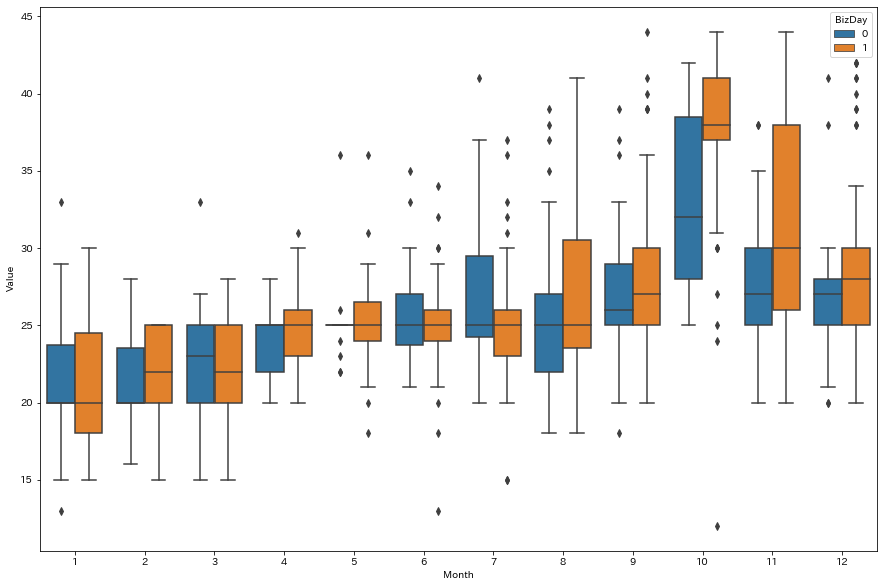

In [76]:
df6 = df3.loc[df3['Metric'].isin(['SizeMax'])]
sns.boxplot(data = df6, x="Month", y="Value", hue="BizDay")